In [1]:
import operator
from typing import Annotated, TypedDict

from IPython.display import Image
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

In [2]:
tool = TavilySearchResults(max_results=2)

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t["name"] in self.tools:
                print("\n Unknown tool name...")
                result = "Unknown tool name, please retry."
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
            )
        print("Back to the model.")
        return {"messages": results}

In [5]:
prompt = """
    You are a smart research assistant. Use the search engine to look up information.
    You are allowed to make multiple calls (either together or in sequence).
    Only look up information when you are sure of what you want.
    If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [6]:
with SqliteSaver.from_conn_string(":memory:") as checkpointer:

    model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    agent = Agent(model, [tool], checkpointer=checkpointer, system=prompt)

    messages = [HumanMessage(content="What is the weather in Berlin?")]
    thread = {"configurable": {"thread_id": "1"}}
    for event in agent.graph.stream({"messages": messages}, thread):
        for v in event.values():
            print(v["messages"])

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Berlin"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-0ab4676d-94d6-4145-9562-b89136702b03-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Berlin'}, 'id': '95260141-4d30-43bd-83b2-b210fb386104', 'type': 'tool_call'}], usage_metadata={'input_tokens': 128, 'output_tokens': 12, 'total_tokens': 140, 'input_token_details': {'cache_read': 0}})]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Berlin'}, 'id': '95260141-4d30-43bd-83b2-b210fb386104', 'type': 'tool_call'}
Back to the model.
[ToolMessage(content='[{\'title\': \'Weather for Berlin, Germany - Time and Date\', \'url\': \'https://www.timeanddate.com/weather/germany/berlin\', \'content\': \'Forecast: 65 / 50 

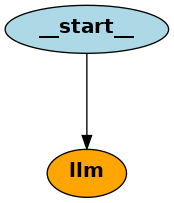

In [7]:
class Agent:

    def __init__(self, model, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.model = model

    def call_llm(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}


model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
agent = Agent(model, checkpointer=checkpointer, system="You are a helpful assistant.")

Image(agent.graph.get_graph().draw_png())

In [8]:
with SqliteSaver.from_conn_string(":memory:") as checkpointer:

    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    agent = Agent(
        model, checkpointer=checkpointer, system="You are a helpful assistant."
    )

    messages = [HumanMessage(content="What is the capital of Germany?")]
    thread = {"configurable": {"thread_id": "0"}}
    result = agent.graph.invoke({"messages": messages}, thread)
    print(result["messages"][-1].content)

    messages = [HumanMessage(content="What was my previous question?")]
    thread = {"configurable": {"thread_id": "0"}}
    result = agent.graph.invoke({"messages": messages}, thread)
    print(result["messages"][-1].content)

    messages = [HumanMessage(content="What was my previous question?")]
    thread = {"configurable": {"thread_id": "1"}}
    result = agent.graph.invoke({"messages": messages}, thread)
    print(result["messages"][-1].content)

The capital of Germany is Berlin.
Your previous question was: "What is the capital of Germany?"
As an AI, I have no memory of past conversations.  Each interaction with me starts fresh.  To know your previous question, you'll need to refer to your own chat history or records.
